## Supervised Learning 
## Project: Finding Donors for *CharityML* 
### Completed April 2019

## Overview
This is the first project of the Udacity Data Scientist Nanodegree

The goal of this project is to employ several supervised learving algorithms to accurately model individuals income using data collected from the 1994 U.S Census. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). 

#### Udacity provided some starter code and recommendations for the steps to take in the analysis 

This project is broken up into the following sections 

* Exploring the data
* Preparing the data 
* Evaluating model performance
* Improving results
* Feature importance 

----
## Exploring the Data

In [37]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display 

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

import visuals as vs

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [39]:
# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [21]:
n_records = len(data.index);
value_counts = data['income'].value_counts(dropna = False);

n_greater_50k = value_counts[1];
n_at_most_50k = value_counts[0];
greater_percent = round((n_greater_50k/n_records)*100,2);

# Print the results
print("Total number of records: {}".format(n_records));
print("Individuals making more than $50,000: {}".format(n_greater_50k));
print("Individuals making at most $50,000: {}".format(n_at_most_50k));
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent));

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data


In [22]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

### Transformation

#### Continuous variables which are concentrated around a certain value but have some values much greater or much lower than the value can cause a negative effect on many algorithms
#### Transforming the data could be a possible solution for this problem
#### Continuous features in this dataset are 'capital-gain' and 'capital-loss'

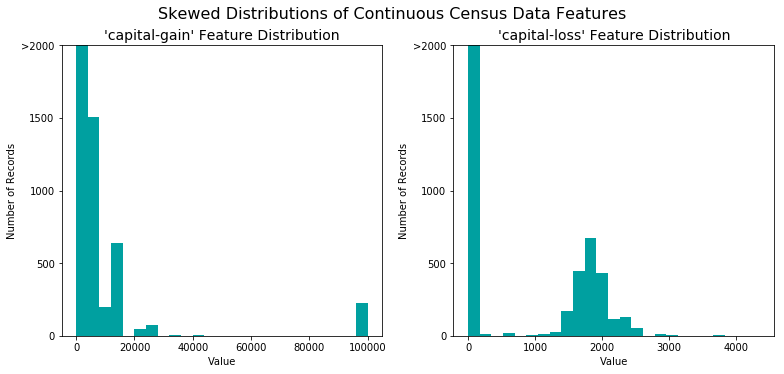

In [23]:
# Visualize skewed continuous features of original data
vs.distribution(data)

#### Using a log transformation can help reduce the effect skewed data

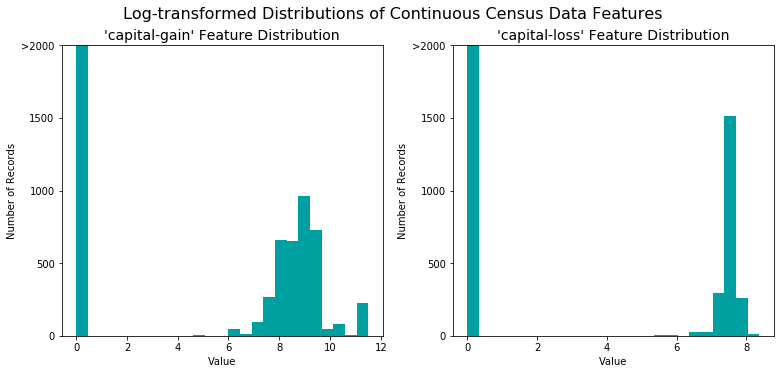

In [24]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

#### After the log transformations the min and max values for 'capital-gain' and 'capital-loss' have been greatly reduced and therefore the skew of the data will have less effect 

### Normalizing Numerical Features

#### After transforming the continuous features we can also normalize the data (making the mean 0 and standard deviation 1). Which maintains the shape of each features distribution but ensures that each feature is weighted equally in the model.

In [25]:
# Normalization 
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing



In [26]:
# Create dummy variables for features 
features_final = pd.get_dummies(features_log_minmax_transform)

# Turns categorical income feature into a numerical value
income = income_raw.astype('category').cat.codes


# Print the number of features after creating dummy variables
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))


103 total features after one-hot encoding.


* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### Shuffle and Split Data
#### For training and testing models I will split the data into 80% train and 20% test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance

### Pros and cons of each model being implemented

Decision Tree 
- They tend to over fit 
- This is a large data set with categorical and numerical data. Decisions Trees also have inherent feature selection so unimportant features will be removed. 

Ensemble (Boosting/Adaboost) 
- If the learners are too weak they can have low margins of improvement when combined together which can lead to over fitting.
- I predict that some features will have a lot more importance than others so boosting will work well for these features. 

Logistic Regression 
- Doesnt handle a large number of features or a lot of categorical well. Relies on non-linear features being transformed. 
- With transformations on the data I think we will arrive close to a linear decision line which will allow logistic regression to work well. 



### Training and Predicting 

In [28]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() 
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() 
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get Predictions 
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-Score
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Initial Model Evaluation


For the sake of comparison I will calculate accuracy and F-Score for the naive estimator (Assuming all are either 0 or 1)

In [29]:
TP = np.sum(income)
FP = income.count() - TP
TN = 0
FN = 0
naive_accuracy = float(TP)/(TP+FP)
recall = float(TP)/(TP+FN)
precision = naive_accuracy

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
naive_fscore = (1+0.5**2)*(precision*recall)/(0.5**2*precision+recall)

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(naive_accuracy, naive_fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


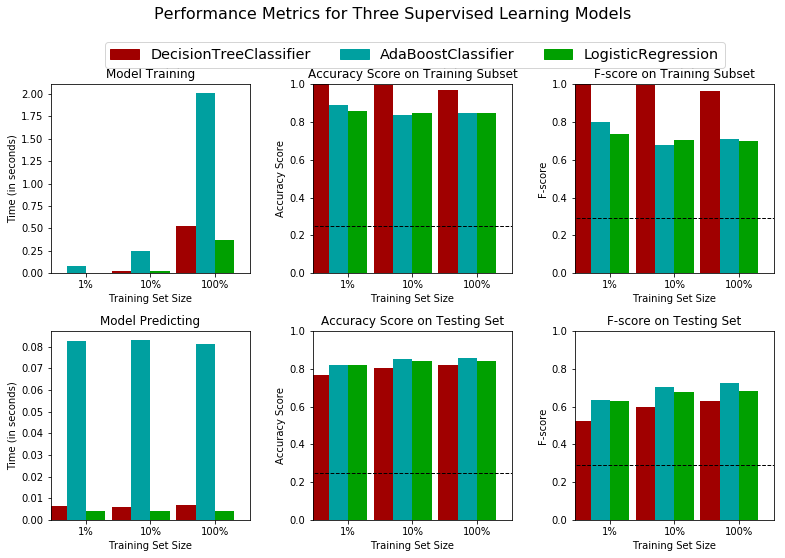

In [30]:
# Initialize the three models
clf_A = DecisionTreeClassifier(random_state = 5 )
clf_B = AdaBoostClassifier(random_state = 5)
clf_C = LogisticRegression(random_state = 5)

samples_100 = int(len(X_train))      # Entire dataset
samples_10 = int(.1*(samples_100))   # 10% of dataset
samples_1 = int(.01*(samples_100))   # 1% of dataset

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

vs.evaluate(results, naive_accuracy, naive_fscore)

----
## Improving Results

### Choosing the Best Model

I believe that the AdaBoostClassifier is the best option for CharityML to identify donors out of the three models. For new data it has the best predictions. This model takes the most time to train and predict out of the three but the difference is small relative to the time of the other models. Other models created good predictions for the data provided but the AdaBoostClassifier will give the best results when new data is applied and the time difference is minimal and irrelevant in this case.

Some of the features have more importance to income than others so the AdabBoostClassifier will weight these features more heavily and reflect them more heavily in the model and hence give a more accurate prediction. 




### Describing the Model in Layman's Terms


The AdaBoostClassifier is a combination of multiple weaker models and combines the best qualities of each one together to make a more accurate model. These weaker models are referred to as "Weak Learners" which only look at a portion of the total features in the data and attempt to classify the data, which makes them come out to slightly better than random chance of correct classification. As this goes on the more accurate a Weak Learner is the more it is reflected in the final model. The data that is misclassified is more likely to be chosen as this process goes on in order to correctly classify the most data. Some of these models will interpret one or more features better than another model can, so this model will be weighted heavier for those features. One model could interpret a feature well but not as well as another model and then not be included at all. We value a model that consistently gives wrong answers because we know to do the opposite of what it is saying. So rather then weighting the predictions of each model evenly we evaluate the models and compare them to combine them in the most efficient way. 

To summarize, we take multiple models that are somewhat good at predicting parts of the data and combine them together to in hopes create a model that is good a predicting using all of the data. Similar to the way a large corporation operates, the CEO has people that specialize in different aspects of the company and the CEO listens to their advice to make a decision, listening to some input more than others. 

### Model Tuning

In [31]:
# Initialize the classifier
clf = AdaBoostClassifier(random_state = 5)

parameters = {'n_estimators' : [100, 50, 25], 'learning_rate' : [.5,1,2]}
scorer = make_scorer(fbeta_score, beta=.5)

#Cross-Validation 
grid_obj = GridSearchCV(clf, parameters, scorer)
grid_fit = grid_obj.fit(X_train,y_train)

# Get the best estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8606
Final F-score on the testing data: 0.7316


#### Optimizing the model using cross validation gives a slight boost in both accuracy and F-Score but nothing drastic

----
## Feature Importance


### Intuition on which features have the most importance



1) Capital Gain - Capital Gain is pure profit from property or investment so this would correlate highly with income  
2) Occupation - Certain occupations get paid more than others on average  
3) Education - More educated people have more value to the workforce  
4) Age - As someone gets older they have longer work experience and get paid more  
5) Hours Per Week - More hours worked means more hours they get paid for  


### Extracting Feature Importance

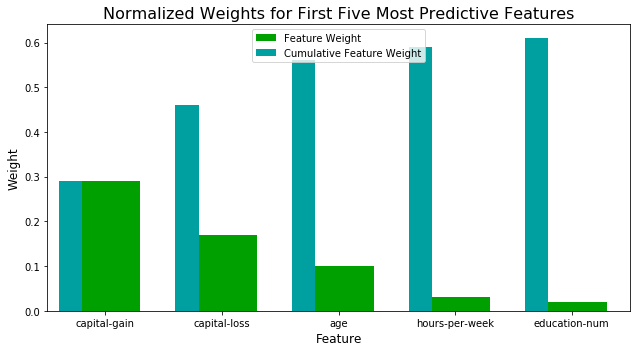

In [35]:
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

#### From the display we see that the order of weights goes 
1.) education-num  
2.) hours-per-week  
3.) age  
4.) capital-loss  
5.) capital-gain  

### Feature Selection

In [38]:

# Reduce the feature space by selecting the five most weighted features
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8606
F-score on testing data: 0.7316

Final Model trained on reduced data
------
Accuracy on testing data: 0.8325
F-score on testing data: 0.6752


### Effects of Feature Selection
The Accuracy score reduces by roughy 1.5% and the F score by roughly 6% and this data will most likely generalize better than with all features included. If training time was a factor I would consider using the reduced data because the model is not drastically effected by the reduction in data and when looking at the training times, using 10% of the data creates a drastic reduction in the training time. Hence, using the less features to reduce the data will be helpful if training time is a factor. 
